In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
data = pd.read_csv('/content/sample_9.csv')

In [ ]:
data.head()

,Unnamed: 0,point_timestamp,point_value
0,0,1997-01-01,3.45
1,1,1997-02-01,2.15
2,2,1997-03-01,1.89
3,3,1997-04-01,2.03
4,4,1997-05-01,2.25


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291 entries, 0 to 290
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       291 non-null    int64  
 1   point_timestamp  291 non-null    object 
 2   point_value      291 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.9+ KB


In [ ]:
data.isnull().sum()

Unnamed: 0         0
point_timestamp    0
point_value        0
dtype: int64

In [ ]:
data.shape

(291, 3)

In [ ]:
dict = {'point_timestamp': 'timestamp', 'point_value':'value'}
data.rename(columns = dict, inplace = True)

In [ ]:
data.set_index('timestamp', inplace = True)

In [ ]:
data.drop('Unnamed: 0', axis = 1, inplace = True)

In [ ]:
data.rename(index={'point_timestamp':'timestamp'}, columns={'point_value':'value'}, inplace=True)
data.head()

,value
timestamp,
1997-01-01,3.45
1997-02-01,2.15
1997-03-01,1.89
1997-04-01,2.03
1997-05-01,2.25


In [ ]:
data.index = pd.to_datetime(data.index)

In [ ]:
import plotly.express as px
fig = px.line(data,  y='value')
fig.show()

In [ ]:
fig = px.bar(data,  y='value')
fig.show()

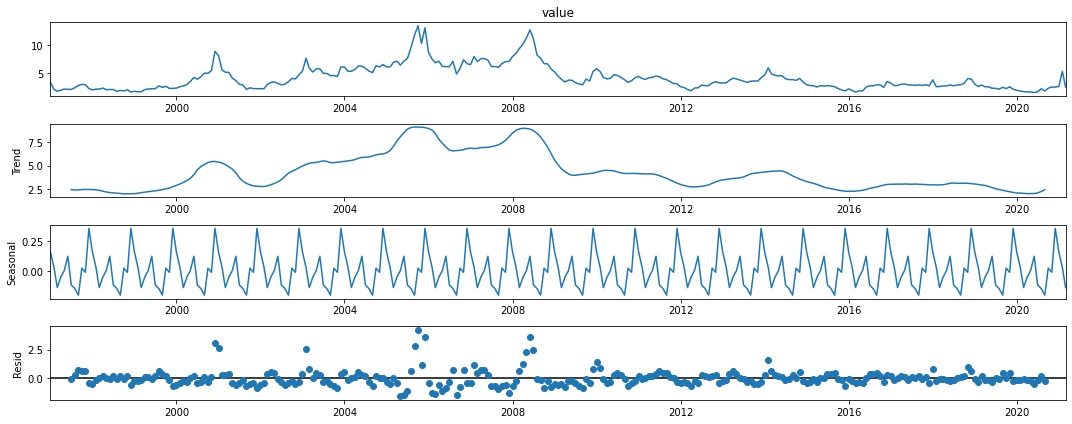

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
rcParams['figure.figsize'] = 15, 6
seasonal_decomposing = seasonal_decompose(data['value'], model='additive',period = 12)
seasonal_decomposing.plot()
pyplot.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('The series is likely stationary.')
    else:
        print('The series is likely non-stationary.')
    
    print(dfoutput)

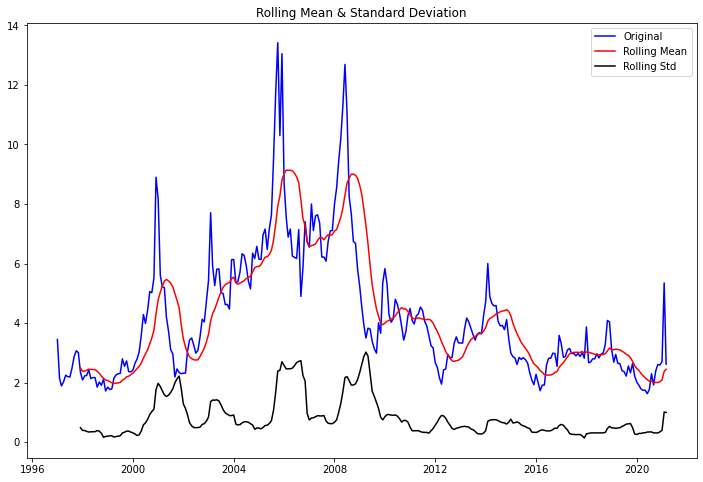

Results of Dickey-Fuller Test:
The series is likely non-stationary.
Test Statistic                  -2.118698
p-value                          0.237063
#Lags Used                       9.000000
Number of Observations Used    281.000000
Critical Value (1%)             -3.453838
Critical Value (5%)             -2.871881
Critical Value (10%)            -2.572280
dtype: float64


In [ ]:
test_stationarity(data)

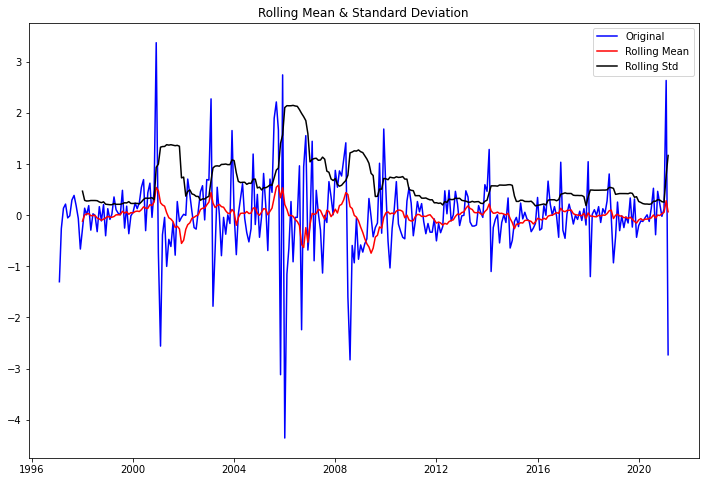

Results of Dickey-Fuller Test:
The series is likely stationary.
Test Statistic                -7.611421e+00
p-value                        2.249855e-11
#Lags Used                     8.000000e+00
Number of Observations Used    2.810000e+02
Critical Value (1%)           -3.453838e+00
Critical Value (5%)           -2.871881e+00
Critical Value (10%)          -2.572280e+00
dtype: float64


In [ ]:
data['difference']=data['value']-data['value'].shift(1)
test_stationarity(data['difference'].dropna())

## Auto Correlation Plot

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

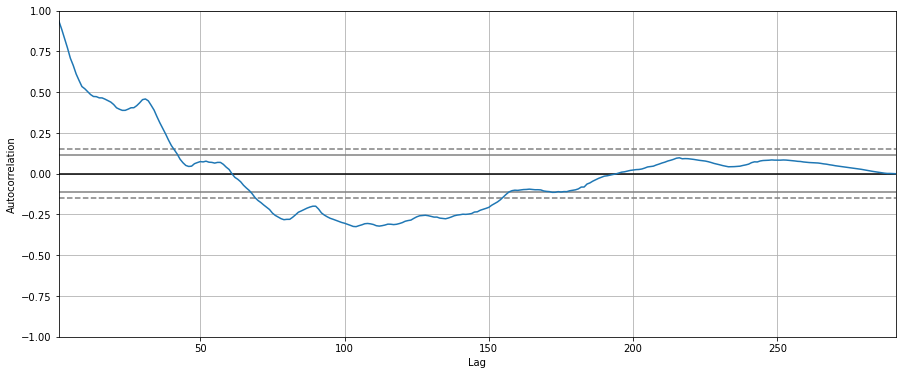

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(data['value'])

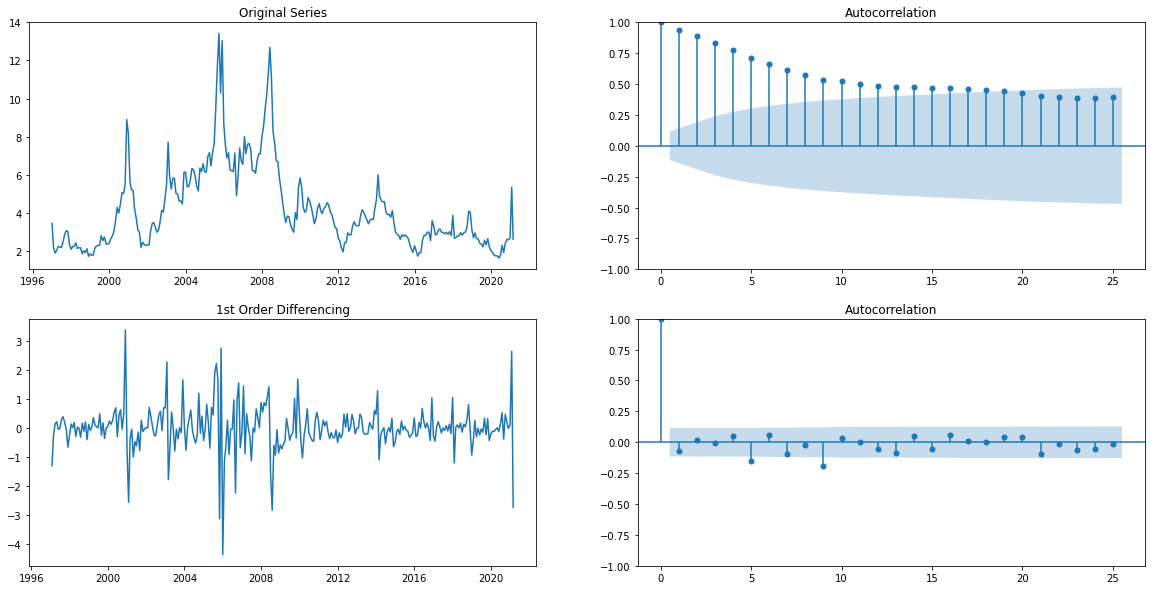

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(2, 2, figsize=(20,10))
axes[0, 0].plot(data['value']); axes[0, 0].set_title('Original Series')
plot_acf(data['value'], ax=axes[0, 1])


axes[1, 0].plot(data['value'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(data['value'].diff().dropna(), ax=axes[1, 1])

plt.show()

In [ ]:
train = data[ :260]
test = data[260: ]

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
from statsmodels.tsa.arima.model import ARIMA 

In [ ]:
data.head()

,value,difference
timestamp,,
1997-01-01,3.45,NaN
1997-02-01,2.15,-1.30
1997-03-01,1.89,-0.26
1997-04-01,2.03,0.14
1997-05-01,2.25,0.22


In [ ]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.6 MB/s eta 0:00:00


In [ ]:
train_ = train.drop(['difference'],axis=1)

In [ ]:
import pmdarima as pm

# fit ARIMA model using auto_arima
model = pm.auto_arima(train_, start_p=1, start_q=1,
                      test='adf',       # use Augmented Dickey-Fuller test to determine stationarity
                      max_p=3, max_q=3,  # maximum p and q values
                      m=1,              # frequency of time series
                      d=None,           # let model determine d value
                      seasonal=False,   # non-seasonal model
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

# print the best model parameters
print(model.order)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=597.220, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=600.133, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=601.804, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=601.822, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=598.134, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=599.054, Time=0.59 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=605.603, Time=0.52 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=603.615, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=603.598, Time=0.21 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=595.222, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=599.823, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=599.805, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=597.055, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=603.605, 

In [ ]:
model.order

(1, 1, 1)

In [ ]:
test.drop('difference', axis = 1)

,value
timestamp,
2018-09-01,3.00
2018-10-01,3.28
2018-11-01,4.09
2018-12-01,4.04
2019-01-01,3.11
2019-02-01,2.69
2019-03-01,2.95
2019-04-01,2.65
2019-05-01,2.64


In [ ]:
results = ARIMA(train_['value'], order = model.order)  
results = results.fit()
print(results.summary()) 

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  260
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -294.611
Date:                Sat, 11 Mar 2023   AIC                            595.222
Time:                        10:23:57   BIC                            605.892
Sample:                    01-01-1997   HQIC                           599.512
                         - 08-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9784      0.026    -37.545      0.000      -1.030      -0.927
ma.L1          0.9466      0.039     24.295      0.000       0.870       1.023
sigma2         0.5691      0.025     22.704      0.0

In [ ]:
forecast = results.forecast(steps=31)

In [ ]:
forecast

2018-09-01    2.992796
2018-10-01    2.960707
2018-11-01    2.992104
2018-12-01    2.961384
2019-01-01    2.991442
2019-02-01    2.962032
2019-03-01    2.990808
2019-04-01    2.962653
2019-05-01    2.990200
2019-06-01    2.963247
2019-07-01    2.989619
2019-08-01    2.963816
2019-09-01    2.989063
2019-10-01    2.964360
2019-11-01    2.988530
2019-12-01    2.964881
2020-01-01    2.988020
2020-02-01    2.965380
2020-03-01    2.987532
2020-04-01    2.965858
2020-05-01    2.987064
2020-06-01    2.966315
2020-07-01    2.986617
2020-08-01    2.966753
2020-09-01    2.986189
2020-10-01    2.967172
2020-11-01    2.985779
2020-12-01    2.967573
2021-01-01    2.985386
2021-02-01    2.967958
2021-03-01    2.985010
Freq: MS, Name: predicted_mean, dtype: float64

In [ ]:
test['error'] = np.array(np.square(forecast - test['value']))

<ipython-input-37-2dcfce1a3fbc>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
sse = sum(test['error'])

In [ ]:
rmse = np.sqrt(sse)
print(rmse)

4.812134181047198


In [ ]:
prediction = results.predict(len(data), len(data)+12)

<AxesSubplot:xlabel='timestamp'>

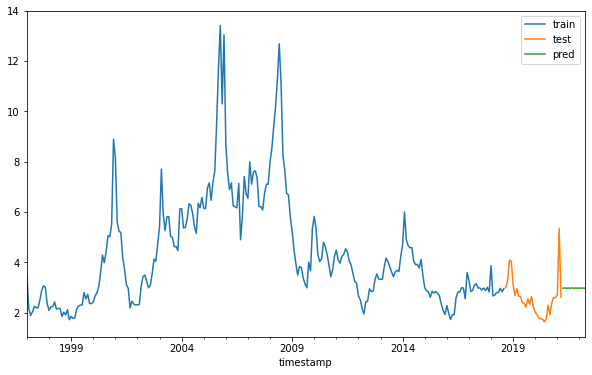

In [ ]:
train['value'].plot(legend = True, label = 'train', figsize = (10,6))
test['value'].plot(legend = True, label = 'test')
prediction.plot(legend = True, label = 'pred')

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
data.head()

,value,difference
timestamp,,
1997-01-01,3.45,NaN
1997-02-01,2.15,-1.30
1997-03-01,1.89,-0.26
1997-04-01,2.03,0.14
1997-05-01,2.25,0.22


In [ ]:
sarima = SARIMAX(endog=train_['value'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), mle_regression=True)

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [ ]:
sarimaResults = sarima.fit()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



In [ ]:
forecast = sarimaResults.forecast(steps=len(test))

<AxesSubplot:xlabel='timestamp'>

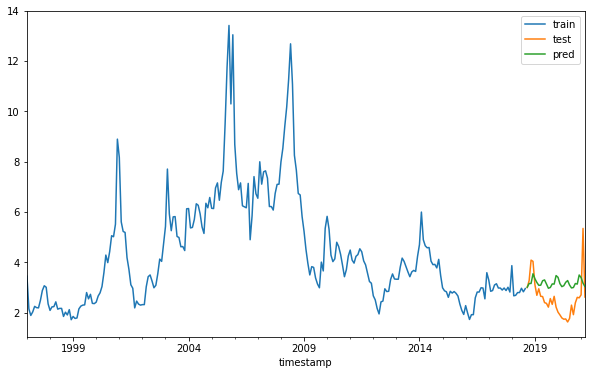

In [ ]:
train['value'].plot(legend = True, label = 'train', figsize = (10,6))
test['value'].plot(legend = True, label = 'test')
forecast.plot(legend = True, label = 'pred')

In [ ]:
future = sarimaResults.forecast(steps=len(test)+12)

<AxesSubplot:xlabel='timestamp'>

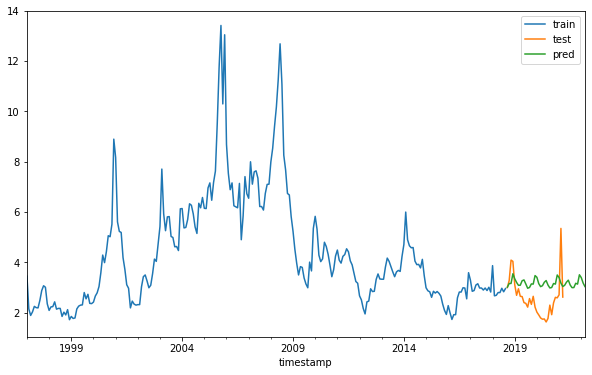

In [ ]:
train['value'].plot(legend = True, label = 'train', figsize = (10,6))
test['value'].plot(legend = True, label = 'test')
future.plot(legend = True, label = 'pred')

In [ ]:
def create_features(df,label = None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]

        return X,y
    return X

In [ ]:
data.head()

,value,difference
timestamp,,
1997-01-01,3.45,NaN
1997-02-01,2.15,-1.30
1997-03-01,1.89,-0.26
1997-04-01,2.03,0.14
1997-05-01,2.25,0.22


In [ ]:
data.drop('difference', axis = 1, inplace = True)

In [ ]:
data.head()

,value
timestamp,
1997-01-01,3.45
1997-02-01,2.15
1997-03-01,1.89
1997-04-01,2.03
1997-05-01,2.25


In [ ]:
xgdata = create_features(data,'value')

<ipython-input-50-e45b2fcaaa36>:12: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [ ]:
xgdata[1]

timestamp
1997-01-01    3.45
1997-02-01    2.15
1997-03-01    1.89
1997-04-01    2.03
1997-05-01    2.25
              ... 
2020-11-01    2.61
2020-12-01    2.59
2021-01-01    2.71
2021-02-01    5.35
2021-03-01    2.62
Name: value, Length: 291, dtype: float64

In [ ]:
xgdata[0]

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
timestamp,,,,,,,
1997-01-01,2,1,1,1997,1,1,1
1997-02-01,5,1,2,1997,32,1,5
1997-03-01,5,1,3,1997,60,1,9
1997-04-01,1,2,4,1997,91,1,14
1997-05-01,3,2,5,1997,121,1,18
...,...,...,...,...,...,...,...
2020-11-01,6,4,11,2020,306,1,44
2020-12-01,1,4,12,2020,336,1,49
2021-01-01,4,1,1,2021,1,1,53


In [ ]:
X_train,y_train,X_test,y_test = xgdata[0][:260], xgdata[1][:260], xgdata[0][260:], xgdata[1][260:]

In [ ]:
X_train

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
timestamp,,,,,,,
1997-01-01,2,1,1,1997,1,1,1
1997-02-01,5,1,2,1997,32,1,5
1997-03-01,5,1,3,1997,60,1,9
1997-04-01,1,2,4,1997,91,1,14
1997-05-01,3,2,5,1997,121,1,18
...,...,...,...,...,...,...,...
2018-04-01,6,2,4,2018,91,1,13
2018-05-01,1,2,5,2018,121,1,18
2018-06-01,4,2,6,2018,152,1,22


In [ ]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

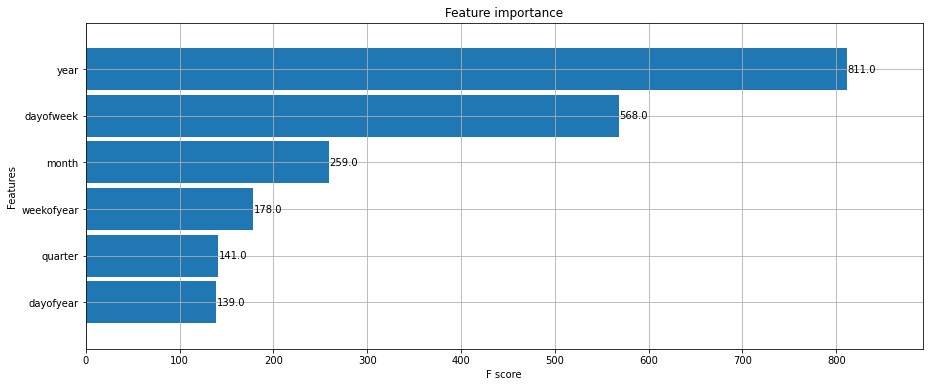

In [ ]:
_ = plot_importance(reg, height=0.9)

In [ ]:
reg.predict(X_test)

array([2.481649, 2.481649, 2.481649, 2.481649, 2.481649, 2.481649,
       2.481649, 2.481649, 2.481649, 2.481649, 2.481649, 2.481649,
       2.481649, 2.481649, 2.481649, 2.481649, 2.481649, 2.481649,
       2.481649, 2.481649, 2.481649, 2.481649, 2.481649, 2.481649,
       2.481649, 2.481649, 2.481649, 2.481649, 2.481649, 2.481649,
       2.481649], dtype=float32)

In [ ]:
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error as mape
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [ ]:
def create_features(df,label = None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]

        return X,y
    return X

In [ ]:
def best_model(dataframe, X_name, y_name, sorder):
  best = {}
  model = pm.auto_arima(dataframe, start_p=1, start_q=1,
                        test='adf',       # use Augmented Dickey-Fuller test to determine stationarity
                        max_p=3, max_q=3,  # maximum p and q values
                        m=1,              # frequency of time series
                        d=None,           # let model determine d value
                        seasonal=False,   # non-seasonal model
                        start_P=0,
                        D=0,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)
  #ARIMA
  results = ARIMA(dataframe.y_name, order = model.order)  
  results = results.fit()
  arimaforecast = results.predict(dataframe.index)
  best['arima_mape'] = mape(arimaforecast, dataframe.y_name)

  #SARIMAX
  sarima = SARIMAX(endog=dataframe.y_name, order=model.order, seasonal_order=(model.order, sorder), mle_regression=True)
  sarimaResults = sarima.fit()
  sarimaforecast = sarimaResults.predict(dataframe.index)
  best['sarima_mape'] = mape(sarimaforecast, dataframe.yname)

  #XGBoost
  xgdata = create_features(data,'value')
  reg = xgb.XGBRegressor(n_estimators=1000)
  reg.fit(xgdata[0], xgdata[1],
          early_stopping_rounds=50,
          verbose=False)
  xgforecast = reg.predict(xgdata[1])
  best['xg_mape'] = mape(xgforecast, dataframe.yname)

  best = dict(sorted(best.items(), key=lambda item: item[1]))
  
  
  for i in best:
    selected_model = i
    its_value = best[i]
    break
  
  if 'arima_mape' == i:
    print(results.summary())
    forecast = results.forecast(steps=31)
    prediction = results.predict(len(data), len(data)+12)
    train['value'].plot(legend = True, label = 'train', figsize = (10,6))
    test['value'].plot(legend = True, label = 'test')
    prediction.plot(legend = True, label = 'pred')


In [ ]:
class ensemble:
  def __init__(self, X_name, y_name, dataframe):
    